In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296kB 8.3MB/s 
/content/gdrive/MyDrive/SEAI_Project


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 1
BITA = 2
BITG = 4

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40, 3], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            if not name.endswith('W'):
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .AvgPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .AvgPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'svhn-dorefa-{}'.format(args)))

    # prepare dataset
    d1 = dataset.SVHNDigit('train')
    d2 = dataset.SVHNDigit('extra')
    data_train = RandomMixData([d1, d2])
    data_test = dataset.SVHNDigit('test')

    augmentors = [
        imgaug.Resize((40, 40)),
        imgaug.Brightness(30),
        imgaug.Contrast((0.5, 1.5)),
    ]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "1,2,4"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0716 13:38:56 @logger.py:128] WRN Log directory train_log/svhn-dorefa-1,2,4 exists! Use 'd' to delete it. 
[0716 13:38:56 @logger.py:131] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):k
[0716 13:39:00 @logger.py:85] Existing log file 'train_log/svhn-dorefa-1,2,4/log.log' backuped to 'train_log/svhn-dorefa-1,2,4/log.log.0716-133900'
[0716 13:39:00 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-58044733-aaf5-4691-8bda-2d09249537d3.json
[0716 13:39:00 @fs.py:101] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[0716 13:39:00 @fs.py:104] Created the directory /root/tensorpack_data.
[0716 13:39:00 @svhn.py:42] File /root/tensorpack_data/svhn_data/train_32x32.mat not found!
[0716 13:39:00 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/train_32x32.mat ...


train_32x32.mat: 182MB [00:03, 53.3MB/s]                           

[0716 13:39:03 @fs.py:73] Succesfully downloaded train_32x32.mat. 182040794 bytes.
[0716 13:39:03 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/train_32x32.mat ...


[0716 13:39:05 @svhn.py:42] File /root/tensorpack_data/svhn_data/extra_32x32.mat not found!
[0716 13:39:05 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/extra_32x32.mat ...


extra_32x32.mat: 1.33GB [01:04, 20.5MB/s]                            

[0716 13:40:10 @fs.py:73] Succesfully downloaded extra_32x32.mat. 1329278602 bytes.
[0716 13:40:10 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/extra_32x32.mat ...


[0716 13:40:22 @svhn.py:42] File /root/tensorpack_data/svhn_data/test_32x32.mat not found!
[0716 13:40:22 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/test_32x32.mat ...


test_32x32.mat: 64.3MB [00:03, 20.9MB/s]                            

[0716 13:40:25 @fs.py:73] Succesfully downloaded test_32x32.mat. 64275384 bytes.
[0716 13:40:25 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/test_32x32.mat ...


[0716 13:40:25 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0716 13:40:25 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0716 13:40:25 @trainers.py:48] Building graph for a single training tower ...
[0716 13:40:25 @<ipython-input-3-92482375c899>:113] Binarizing weight conv0/W
[0716 13:40:25 @registry.py:90] 'conv0': [?, 40, 40, 3] --> [?, 36, 36, 48]
[0716 13:40:25 @registry.py:90] 'pool0': [?, 36, 36, 48] --> [?, 18, 18, 48]
[0716 13:40:25 @<ipython-input-3-92482375c899>:113] Binarizing weight conv1/W
[0716 13:40:25 @registry.py:90] 'conv1': [?, 18, 18, 48] --> [?, 18, 18, 64]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizing weight conv2/W
[0716 13:40:26 @registry.py:90] 'conv2': [?, 18, 18, 64] --> [?, 18, 18, 64]
[0716 13:40:26 @registry.py:90] 'pool1': [?, 18, 18, 64] --> [?, 9, 9, 64]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0716 13:40:26 @registry.py:90] 'conv3': [?, 9, 9, 64] --> [?, 7, 7, 128]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizing weight conv4/W
[0716 13:40:26 @registry.py:90] 'conv4': [?, 7, 7, 128] --> [?, 7, 7, 128]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizing weight conv5/W
[0716 13:40:26 @registry.py:90] 'conv5': [?, 7, 7, 128] --> [?, 5, 5, 128]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizing weight conv6/W
[0716 13:40:26 @registry.py:90] 'conv6': [?, 5, 5, 128] --> [?, 1, 1, 512]
[0716 13:40:26 @<ipython-input-3-92482375c899>:113] Binarizing weight fc1/W
[0716 13:40:26 @registry.py:90] 'fc1': [?, 1, 1, 512] --> [?, 10]
[0716 13:40:26 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0716 13:40:26 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0716 13:40:27 @model_utils.py:67] List of Trainable Variables: 
name       shape               #elements
---------  ----------------  -----------
conv0/W 

100%|##########|4721/4721[04:30<00:00,17.45it/s]

[0716 13:45:08 @base.py:283] Epoch 1 (global_step 4721) finished, time:4 minutes 30 seconds.


[0716 13:45:08 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-4721.


100%|##########|204/204[00:10<00:00,18.89it/s]

[0716 13:45:19 @monitor.py:476] QueueInput/queue_size: 17.5
[0716 13:45:19 @monitor.py:476] accuracy: 0.9514
[0716 13:45:19 @monitor.py:476] cost: 0.17174
[0716 13:45:19 @monitor.py:476] cross_entropy_loss: 0.17174
[0716 13:45:19 @monitor.py:476] param-summary/conv0/W-rms: 0.18579
[0716 13:45:19 @monitor.py:476] param-summary/conv1/W-rms: 0.079097
[0716 13:45:19 @monitor.py:476] param-summary/conv2/W-rms: 0.073921
[0716 13:45:19 @monitor.py:476] param-summary/conv3/W-rms: 0.078041
[0716 13:45:19 @monitor.py:476] param-summary/conv4/W-rms: 0.065342
[0716 13:45:19 @monitor.py:476] param-summary/conv5/W-rms: 0.069217
[0716 13:45:19 @monitor.py:476] param-summary/conv6/W-rms: 0.054508
[0716 13:45:19 @monitor.py:476] param-summary/fc1/W-rms: 0.11674
[0716 13:45:19 @monitor.py:476] regularize_cost: 3.4822e-06
[0716 13:45:19 @monitor.py:476] train_error: 0.048603
[0716 13:45:19 @monitor.py:476] val_accuracy: 0.91836
[0716 13:45:19 @monitor.py:476] val_cross_entropy_loss: 0.28042
[0716 13:45:1


100%|##########|4721/4721[04:03<00:00,19.42it/s]

[0716 13:49:22 @base.py:283] Epoch 2 (global_step 9442) finished, time:4 minutes 3 seconds.
[0716 13:49:22 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-9442.



100%|##########|204/204[00:09<00:00,21.23it/s]

[0716 13:49:32 @monitor.py:476] QueueInput/queue_size: 0.125
[0716 13:49:32 @monitor.py:476] accuracy: 0.95954
[0716 13:49:32 @monitor.py:476] cost: 0.12696
[0716 13:49:32 @monitor.py:476] cross_entropy_loss: 0.12695
[0716 13:49:32 @monitor.py:476] param-summary/conv0/W-rms: 0.21594
[0716 13:49:32 @monitor.py:476] param-summary/conv1/W-rms: 0.095424
[0716 13:49:32 @monitor.py:476] param-summary/conv2/W-rms: 0.096639
[0716 13:49:32 @monitor.py:476] param-summary/conv3/W-rms: 0.10256
[0716 13:49:32 @monitor.py:476] param-summary/conv4/W-rms: 0.090783
[0716 13:49:32 @monitor.py:476] param-summary/conv5/W-rms: 0.095921
[0716 13:49:32 @monitor.py:476] param-summary/conv6/W-rms: 0.080853
[0716 13:49:32 @monitor.py:476] param-summary/fc1/W-rms: 0.15417
[0716 13:49:32 @monitor.py:476] regularize_cost: 6.0714e-06
[0716 13:49:32 @monitor.py:476] train_error: 0.040459
[0716 13:49:32 @monitor.py:476] val_accuracy: 0.9346
[0716 13:49:32 @monitor.py:476] val_cross_entropy_loss: 0.2344


[0716 13:49:32 @group.py:44] Callbacks took 9.864 sec in total. InferenceRunner: 9.63 seconds
[0716 13:49:32 @base.py:273] Start Epoch 3 ...


100%|##########|4721/4721[04:05<00:00,19.25it/s]

[0716 13:53:37 @base.py:283] Epoch 3 (global_step 14163) finished, time:4 minutes 5 seconds.
[0716 13:53:37 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-14163.



100%|##########|204/204[00:09<00:00,21.46it/s]

[0716 13:53:47 @monitor.py:476] QueueInput/queue_size: 1.4927e-08
[0716 13:53:47 @monitor.py:476] accuracy: 0.96718
[0716 13:53:47 @monitor.py:476] cost: 0.11572
[0716 13:53:47 @monitor.py:476] cross_entropy_loss: 0.11571
[0716 13:53:47 @monitor.py:476] param-summary/conv0/W-rms: 0.24038
[0716 13:53:47 @monitor.py:476] param-summary/conv1/W-rms: 0.11408
[0716 13:53:47 @monitor.py:476] param-summary/conv2/W-rms: 0.11999
[0716 13:53:47 @monitor.py:476] param-summary/conv3/W-rms: 0.1263
[0716 13:53:47 @monitor.py:476] param-summary/conv4/W-rms: 0.11397
[0716 13:53:47 @monitor.py:476] param-summary/conv5/W-rms: 0.1194
[0716 13:53:47 @monitor.py:476] param-summary/conv6/W-rms: 0.1028
[0716 13:53:47 @monitor.py:476] param-summary/fc1/W-rms: 0.18507
[0716 13:53:47 @monitor.py:476] regularize_cost: 8.7553e-06
[0716 13:53:47 @monitor.py:476] train_error: 0.032823
[0716 13:53:47 @monitor.py:476] val_accuracy: 0.9481
[0716 13:53:47 @monitor.py:476] val_cross_entropy_loss: 0.19385
[0716 13:53:47 @


100%|##########|4721/4721[04:05<00:00,19.23it/s]

[0716 13:57:53 @base.py:283] Epoch 4 (global_step 18884) finished, time:4 minutes 5 seconds.
[0716 13:57:53 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-18884.



100%|##########|204/204[00:09<00:00,20.71it/s]

[0716 13:58:03 @monitor.py:476] QueueInput/queue_size: 1.3885e-17
[0716 13:58:03 @monitor.py:476] accuracy: 0.97246
[0716 13:58:03 @monitor.py:476] cost: 0.10792
[0716 13:58:03 @monitor.py:476] cross_entropy_loss: 0.10791
[0716 13:58:03 @monitor.py:476] param-summary/conv0/W-rms: 0.25949
[0716 13:58:03 @monitor.py:476] param-summary/conv1/W-rms: 0.13054
[0716 13:58:03 @monitor.py:476] param-summary/conv2/W-rms: 0.14091
[0716 13:58:03 @monitor.py:476] param-summary/conv3/W-rms: 0.14817
[0716 13:58:03 @monitor.py:476] param-summary/conv4/W-rms: 0.13491
[0716 13:58:03 @monitor.py:476] param-summary/conv5/W-rms: 0.1409
[0716 13:58:03 @monitor.py:476] param-summary/conv6/W-rms: 0.12108
[0716 13:58:03 @monitor.py:476] param-summary/fc1/W-rms: 0.21065
[0716 13:58:03 @monitor.py:476] regularize_cost: 1.1334e-05
[0716 13:58:03 @monitor.py:476] train_error: 0.027544
[0716 13:58:03 @monitor.py:476] val_accuracy: 0.95005
[0716 13:58:03 @monitor.py:476] val_cross_entropy_loss: 0.19149
[0716 13:58:0


100%|##########|4721/4721[04:06<00:00,19.11it/s]

[0716 14:02:10 @base.py:283] Epoch 5 (global_step 23605) finished, time:4 minutes 7 seconds.
[0716 14:02:10 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-23605.



100%|##########|204/204[00:09<00:00,21.94it/s]

[0716 14:02:19 @monitor.py:476] QueueInput/queue_size: 7.6611e-06
[0716 14:02:19 @monitor.py:476] accuracy: 0.97374
[0716 14:02:19 @monitor.py:476] cost: 0.093331
[0716 14:02:19 @monitor.py:476] cross_entropy_loss: 0.093316
[0716 14:02:19 @monitor.py:476] param-summary/conv0/W-rms: 0.2764
[0716 14:02:19 @monitor.py:476] param-summary/conv1/W-rms: 0.14687
[0716 14:02:19 @monitor.py:476] param-summary/conv2/W-rms: 0.16057
[0716 14:02:19 @monitor.py:476] param-summary/conv3/W-rms: 0.16751
[0716 14:02:19 @monitor.py:476] param-summary/conv4/W-rms: 0.1537
[0716 14:02:19 @monitor.py:476] param-summary/conv5/W-rms: 0.1608
[0716 14:02:19 @monitor.py:476] param-summary/conv6/W-rms: 0.13727
[0716 14:02:19 @monitor.py:476] param-summary/fc1/W-rms: 0.23683
[0716 14:02:19 @monitor.py:476] regularize_cost: 1.4342e-05
[0716 14:02:19 @monitor.py:476] train_error: 0.026265
[0716 14:02:19 @monitor.py:476] val_accuracy: 0.9559
[0716 14:02:19 @monitor.py:476] val_cross_entropy_loss: 0.16807
[0716 14:02:19


100%|##########|4721/4721[04:08<00:00,18.98it/s]

[0716 14:06:28 @base.py:283] Epoch 6 (global_step 28326) finished, time:4 minutes 8 seconds.
[0716 14:06:28 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-28326.



100%|##########|204/204[00:09<00:00,21.76it/s]

[0716 14:06:38 @monitor.py:476] QueueInput/queue_size: 0.0019531
[0716 14:06:38 @monitor.py:476] accuracy: 0.97299
[0716 14:06:38 @monitor.py:476] cost: 0.087401
[0716 14:06:38 @monitor.py:476] cross_entropy_loss: 0.087383
[0716 14:06:38 @monitor.py:476] param-summary/conv0/W-rms: 0.28857
[0716 14:06:38 @monitor.py:476] param-summary/conv1/W-rms: 0.16188
[0716 14:06:38 @monitor.py:476] param-summary/conv2/W-rms: 0.17928
[0716 14:06:38 @monitor.py:476] param-summary/conv3/W-rms: 0.18623
[0716 14:06:38 @monitor.py:476] param-summary/conv4/W-rms: 0.17088
[0716 14:06:38 @monitor.py:476] param-summary/conv5/W-rms: 0.1789
[0716 14:06:38 @monitor.py:476] param-summary/conv6/W-rms: 0.15179
[0716 14:06:38 @monitor.py:476] param-summary/fc1/W-rms: 0.26283
[0716 14:06:38 @monitor.py:476] regularize_cost: 1.7671e-05
[0716 14:06:38 @monitor.py:476] train_error: 0.02701
[0716 14:06:38 @monitor.py:476] val_accuracy: 0.9574
[0716 14:06:38 @monitor.py:476] val_cross_entropy_loss: 0.16052
[0716 14:06:38


100%|##########|4721/4721[04:03<00:00,19.39it/s]

[0716 14:10:41 @base.py:283] Epoch 7 (global_step 33047) finished, time:4 minutes 3 seconds.
[0716 14:10:41 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-33047.



100%|##########|204/204[00:09<00:00,21.74it/s]

[0716 14:10:51 @monitor.py:476] QueueInput/queue_size: 0.064484
[0716 14:10:51 @monitor.py:476] accuracy: 0.97438
[0716 14:10:51 @monitor.py:476] cost: 0.090261
[0716 14:10:51 @monitor.py:476] cross_entropy_loss: 0.09024
[0716 14:10:51 @monitor.py:476] param-summary/conv0/W-rms: 0.3014
[0716 14:10:51 @monitor.py:476] param-summary/conv1/W-rms: 0.17805
[0716 14:10:51 @monitor.py:476] param-summary/conv2/W-rms: 0.19681
[0716 14:10:51 @monitor.py:476] param-summary/conv3/W-rms: 0.20279
[0716 14:10:51 @monitor.py:476] param-summary/conv4/W-rms: 0.18721
[0716 14:10:51 @monitor.py:476] param-summary/conv5/W-rms: 0.19505
[0716 14:10:51 @monitor.py:476] param-summary/conv6/W-rms: 0.16499
[0716 14:10:51 @monitor.py:476] param-summary/fc1/W-rms: 0.28735
[0716 14:10:51 @monitor.py:476] regularize_cost: 2.1124e-05
[0716 14:10:51 @monitor.py:476] train_error: 0.02562
[0716 14:10:51 @monitor.py:476] val_accuracy: 0.95861
[0716 14:10:51 @monitor.py:476] val_cross_entropy_loss: 0.15994
[0716 14:10:51 


100%|##########|4721/4721[04:04<00:00,19.35it/s]

[0716 14:14:55 @base.py:283] Epoch 8 (global_step 37768) finished, time:4 minutes 4 seconds.
[0716 14:14:55 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-37768.



100%|##########|204/204[00:09<00:00,20.86it/s]

[0716 14:15:05 @monitor.py:476] QueueInput/queue_size: 0.015672
[0716 14:15:05 @monitor.py:476] accuracy: 0.97368
[0716 14:15:05 @monitor.py:476] cost: 0.096085
[0716 14:15:05 @monitor.py:476] cross_entropy_loss: 0.09606
[0716 14:15:05 @monitor.py:476] param-summary/conv0/W-rms: 0.31298
[0716 14:15:05 @monitor.py:476] param-summary/conv1/W-rms: 0.19409
[0716 14:15:05 @monitor.py:476] param-summary/conv2/W-rms: 0.21388
[0716 14:15:05 @monitor.py:476] param-summary/conv3/W-rms: 0.21813
[0716 14:15:05 @monitor.py:476] param-summary/conv4/W-rms: 0.20263
[0716 14:15:05 @monitor.py:476] param-summary/conv5/W-rms: 0.21149
[0716 14:15:05 @monitor.py:476] param-summary/conv6/W-rms: 0.17743
[0716 14:15:05 @monitor.py:476] param-summary/fc1/W-rms: 0.31147
[0716 14:15:05 @monitor.py:476] regularize_cost: 2.4829e-05
[0716 14:15:05 @monitor.py:476] train_error: 0.026321
[0716 14:15:05 @monitor.py:476] val_accuracy: 0.95447
[0716 14:15:05 @monitor.py:476] val_cross_entropy_loss: 0.17118
[0716 14:15:0


100%|##########|4721/4721[04:03<00:00,19.39it/s]

[0716 14:19:08 @base.py:283] Epoch 9 (global_step 42489) finished, time:4 minutes 3 seconds.
[0716 14:19:09 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-42489.



100%|##########|204/204[00:09<00:00,21.66it/s]

[0716 14:19:18 @monitor.py:476] QueueInput/queue_size: 0.25
[0716 14:19:18 @monitor.py:476] accuracy: 0.97917
[0716 14:19:18 @monitor.py:476] cost: 0.069874
[0716 14:19:18 @monitor.py:476] cross_entropy_loss: 0.069845
[0716 14:19:18 @monitor.py:476] param-summary/conv0/W-rms: 0.32198
[0716 14:19:18 @monitor.py:476] param-summary/conv1/W-rms: 0.20752
[0716 14:19:18 @monitor.py:476] param-summary/conv2/W-rms: 0.2301
[0716 14:19:18 @monitor.py:476] param-summary/conv3/W-rms: 0.23279
[0716 14:19:18 @monitor.py:476] param-summary/conv4/W-rms: 0.21691
[0716 14:19:18 @monitor.py:476] param-summary/conv5/W-rms: 0.22623
[0716 14:19:18 @monitor.py:476] param-summary/conv6/W-rms: 0.18883
[0716 14:19:18 @monitor.py:476] param-summary/fc1/W-rms: 0.3351
[0716 14:19:18 @monitor.py:476] regularize_cost: 2.8717e-05
[0716 14:19:18 @monitor.py:476] train_error: 0.020835
[0716 14:19:18 @monitor.py:476] val_accuracy: 0.96072
[0716 14:19:18 @monitor.py:476] val_cross_entropy_loss: 0.15237
[0716 14:19:18 @gr


100%|##########|4721/4721[04:06<00:00,19.12it/s]

[0716 14:23:25 @base.py:283] Epoch 10 (global_step 47210) finished, time:4 minutes 6 seconds.
[0716 14:23:25 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-47210.



100%|##########|204/204[00:09<00:00,21.64it/s]

[0716 14:23:35 @monitor.py:476] QueueInput/queue_size: 1.5613e-17
[0716 14:23:35 @monitor.py:476] accuracy: 0.98196
[0716 14:23:35 @monitor.py:476] cost: 0.072017
[0716 14:23:35 @monitor.py:476] cross_entropy_loss: 0.071984
[0716 14:23:35 @monitor.py:476] param-summary/conv0/W-rms: 0.3309
[0716 14:23:35 @monitor.py:476] param-summary/conv1/W-rms: 0.21778
[0716 14:23:35 @monitor.py:476] param-summary/conv2/W-rms: 0.24496
[0716 14:23:35 @monitor.py:476] param-summary/conv3/W-rms: 0.2477
[0716 14:23:35 @monitor.py:476] param-summary/conv4/W-rms: 0.23059
[0716 14:23:35 @monitor.py:476] param-summary/conv5/W-rms: 0.24064
[0716 14:23:35 @monitor.py:476] param-summary/conv6/W-rms: 0.19956
[0716 14:23:35 @monitor.py:476] param-summary/fc1/W-rms: 0.35869
[0716 14:23:35 @monitor.py:476] regularize_cost: 3.292e-05
[0716 14:23:35 @monitor.py:476] train_error: 0.018036
[0716 14:23:35 @monitor.py:476] val_accuracy: 0.96133
[0716 14:23:35 @monitor.py:476] val_cross_entropy_loss: 0.14913
[0716 14:23:3

"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

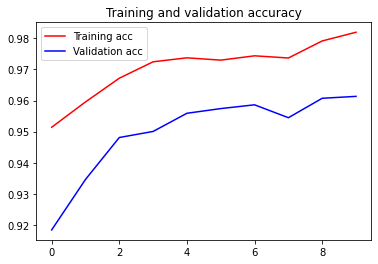

<Figure size 432x288 with 0 Axes>

In [4]:
import json
import matplotlib.pyplot as plt

f = open("train_log/svhn-dorefa-1,2,4/stats_def_first&last_avg_pooling.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [5]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.951397 │
├──────────┼────────────┤
│        2 │   0.959541 │
├──────────┼────────────┤
│        3 │   0.967177 │
├──────────┼────────────┤
│        4 │   0.972456 │
├──────────┼────────────┤
│        5 │   0.973735 │
├──────────┼────────────┤
│        6 │   0.97299  │
├──────────┼────────────┤
│        7 │   0.97438  │
├──────────┼────────────┤
│        8 │   0.973679 │
├──────────┼────────────┤
│        9 │   0.979165 │
├──────────┼────────────┤
│       10 │   0.981964 │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.918365 │
├──────────┼────────────┤
│        2 │   0.934602 │
├──────────┼────────────┤
│        3 │   0.948095 │
├──────────┼────────────┤
│        4 │   0.950049 │
├──────────┼────────────┤
│        5 │   0.955895 │
├──────────┼────────────┤
│        6 │   0.957401 │
├─────